### This is the code that uploads an image, demages it using a mask (that it also uploads) and than solves a Laplace equation with the boudnary conditions on the border on the image to restore the original image. Solution using the Jocobi method

In [5]:
# %matplotlib widget #If viewed in Jupyter lab
# calling it a second time may prevent some graphics errors
%matplotlib notebook

from PIL import Image
import numpy as np
import sys
from matplotlib import pyplot as plt
# For printing out all the cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#### I don't get why it does not allow me to save the image

In [6]:
#Mask.point(lambda x: 0 if x<128 else 255, '1')
# img2=Image.open('Pics\serveimage.jpg',mode='r')
# img2.save("Name.jpg")
# img.close()

### Upload an image, the mask, convert to grayscale and demage the image

<IPython.core.display.Javascript object>


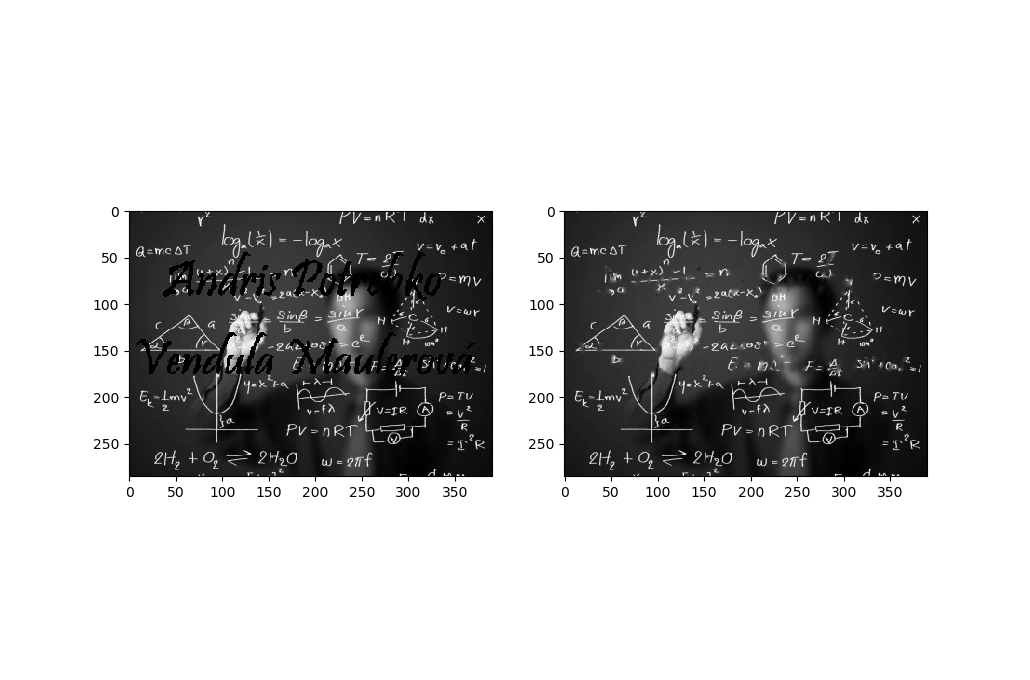

In [44]:
img = Image.open('Pics\serveimage.jpg', mode='r').convert('L')
Mask = Image.open('Pics\TheMask.png', mode='r').convert('L')

I = np.asarray(img).copy()  # Copy so that you can update the file
MaskMat = np.asarray(Mask).copy()

MaskMat[MaskMat < 128] = 0    # Black
MaskMat[MaskMat >= 128] = 255  # White
IDem = I.copy()

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10.3, 6.8)
#plt.imshow(MaskMat, cmap='gray', interpolation='nearest')
IDem[MaskMat == 0] = 0
# sum(MaskMat==0)+sum(MaskMat==255)
ax1.imshow(IDem, cmap='gray', interpolation='nearest')


### Define the positions of the demaged regions and boundary conditions
* We find the outer border of the demage and define the boundary values "bc" to have the value 0 everywhere excpet on the boundary, where it has the value of the previous picture

In [8]:
from PIL import ImageFilter
import PIL.ImageOps

# This gives the outer border - where we can take the border conditions
borderInv1 = PIL.ImageOps.invert(Mask).filter(ImageFilter.CONTOUR)
borderInv = np.asarray(borderInv1)

# border1 = Mask.filter(ImageFilter.CONTOUR)  # iner border. Don't need anymore
# border = np.asarray(border1)

# Check with the plot above if the border lies where it should
# I[borderInv == 0] = 255
# I[border == 0] = 0
# plt.imshow(I, cmap='gray', interpolation='nearest')

# Another check
# np.max(I[borderInv == 0]) #The value is not 255 which means that it is not the border - black

bc = np.zeros([len(I), len(I[1])])
bc[borderInv != 255] = IDem[borderInv != 255]
bc[:, [0, -1]] = 0  # Otherwise there are problems at the border of the image
bc[[0, -1], :] = 0
ax2.imshow(bc, cmap='gray')

In [45]:
ax2.imshow(IRes, cmap='gray')

## Begin the Jecobi method
### Define the initial values for all u inside as the average of the boundary

In [9]:
NIter = 20
InnerPts = np.zeros((NIter, len(I), len(I[0])))  # Inner points at any time

Pts0 = np.array([[-1]*len(I[0])]*len(I))
# InerPts=np.zeros([len(I),len(I[1])])   #[[1]*len(I[1])]*len(I)
Pts0[IDem == 0] = np.mean(bc[borderInv == 0])
Pts0[0, 0] = 255  # otherwise you don't see it in the image

# InitVal
ax1.imshow(Pts0, cmap='gray')
InnerPts = np.append([Pts0], InnerPts, axis=0)
#MaskMat[MaskMat == np.mean(bc[borderInv == 0])]

### Define the fuction which will calculate the next step

In [10]:
N2d = 4
NB = 0  # Nr of vonNeuman boundaries


def JacobyMeth(t, j, k, *args):
    # print(j,k)
    # [u11, u21, u12, u22]
    Indx = np.array([[j-1, k], [j+1, k], [j, k-1], [j, k+1]])
    uNeigh = InnerPts[t, Indx[:, 0], Indx[:, 1]]
    for i, indc in enumerate(Indx):
        if bc[indc[0], indc[1]] != 0:
            uNeigh[i] = bc[indc[0], indc[1]]
#         print(bc[indc[0],indc[1]])
    # print(N2d,NB,sum(uNeigh))
    InnerPts[t+1, j, k] = 1/(N2d-NB)*(sum(uNeigh))  # +rho=0

### Run iterations

In [11]:
%%time
for t in range(NIter):
    # -1 because otherwise there are errors in when looking at the postition to the right.
    # There are anyway no changes at the right border
    for j in range(len(InnerPts[0])-1):   
        for k in range(len(InnerPts[0][0])-1):
            if Pts0[j, k] == -1:
                continue
            JacobyMeth(t, j, k)

Wall time: 23.8 s


In [12]:
# [j, k] = [282, 2]
# # [u11, u21, u12, u22]
# Indx = np.array([[j-1, k], [j+1, k], [j, k-1], [j, k+1]])
# uNeigh = InnerPts[t, Indx[:, 0], Indx[:, 1]]
# uNeigh = [InnerPts[t,Indx[0][0],Indx[0][1]], InnerPts[t,Indx[0][0],Indx[0][1]], InnerPts[t,Indx[0][0],Indx[0][1]], InnerPts[t,Indx[0][0],Indx[0][1]]
# NB=0  #Nr of boundary sites
# for i ,indc in enumerate(Indx):
#     print(indc)
#     if bc[indc[0],indc[1]] != 0:
#         print(bc[indc[0],indc[1]])
#         uNeigh[i] = bc[indc[0], indc[1]]
#         NB+=1

### Plot the result

<IPython.core.display.Javascript object>


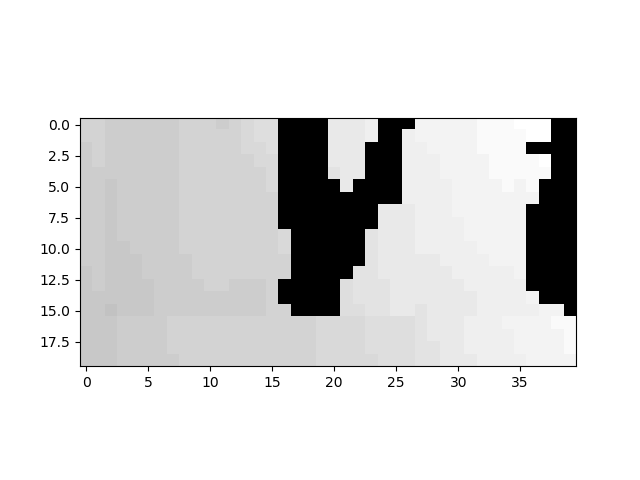

In [55]:
IRes=IDem.copy()
IRes[MaskMat == 0] = InnerPts[NIter][MaskMat == 0] 
fig2, ax3 = plt.subplots()
ax3.imshow(IRes, cmap='gray', interpolation='nearest')
#ax3.imshow(InnerPts[1], cmap='gray', interpolation='nearest')

### Check the convergance

In [94]:
# Co = [160,5, 180, 45]
# Co = [140,5,190,50]
# #Co = [100, 5, 180, 100]
# Itemp = I[Co[0]:Co[2],Co[1]:Co[3]]
# MaskTemp = MaskMat[Co[0]:Co[2],Co[1]:Co[3]]
# ResTemp = IRes[Co[0]:Co[2],Co[1]:Co[3]]
# Idamag = Itemp[MaskTemp == 0]
# sigI = np.std(Idamag)**2
# n=len(Idamag)
# Ksi2 = 1/n * np.sum((ResTemp-Itemp)**2 ) / sigI**2

# fig4, (ax5, ax6,ax7) = plt.subplots(1,3)
# ax5.imshow(Itemp, cmap='gray', interpolation='nearest')
# ax6.imshow(ResTemp, cmap='gray', interpolation='nearest')
# #ax6.imshow(ResTemp, cmap='gray', interpolation='nearest')

In [16]:
# np.std(I)**2
# np.sum((np.mean(I)-I)**2)/(len(I)*len(I[0]-1))
Idamag = I[MaskMat == 0]
sigI = np.std(Idamag)**2
n=len(Idamag)
Ksi2 = 1/n * np.sum((IRes-I)**2 ) / sigI**2
Ksi2
#len(I)
#I[MaskMat == 0]

9.256524596083994e-06

### Comparison between $\chi^2$ squares at different image locations
* In the first line define the pixels that want to analyze and then run the function for calculating $\chi^2$ for any location
* First we notice that $\chi^2$ is larger for VCo3 - where we look at the damage at the plain background. And it is larger than for highly changing background like VCo2. It might seem that it does not make sense because the highly changing background is appearantly worse recovered. You can see it by naked eye. But what causes this effect is the division by $\sigma^2$ in the $\chi^2$, which normalises the result by how changing is the result. Thus, the good result for VCo2 actually shows that the method is good at recovering also the chaning background

* The worst result of the rest is than for *An* part which has many different small changes in the background


In [95]:
AnCo = [50,30,94,96]
MaCo = [130, 170, 180, 240]
KoCo= [40,295,100,340]
dCo = [130,85,180,115]
VCo=[135,5,155,45]
VCo2 = [135,5,180,45]
VCo3 = [160,5, 180, 45]
WholeCo = [0,0,220,340]

def FindKsi(Co, *args):
    Itemp = I[Co[0]:Co[2],Co[1]:Co[3]]
    MaskTemp = MaskMat[Co[0]:Co[2],Co[1]:Co[3]]
    ResTemp = IRes[Co[0]:Co[2],Co[1]:Co[3]]
    Idamag = Itemp[MaskTemp == 0]
    sigI = np.std(Idamag)**2
    n=len(Idamag)
    Ksi2 = 1/n * np.sum((ResTemp-Itemp)**2 ) / sigI**2
    ax3.imshow(IDem[Co[0]:Co[2],Co[1]:Co[3] ], cmap='gray', interpolation='nearest')
    print("SigI = ",sigI, " Ksi2 = ", Ksi2)
#     return Ksi2

FindKsi(AnCo)
FindKsi(MaCo)
FindKsi(KoCo)
FindKsi(dCo)
FindKsi(WholeCo)
FindKsi(VCo)
FindKsi(VCo2)
FindKsi(VCo3)

SigI =  1592.4555177278462  Ksi2 =  1.8610812808847236e-05
SigI =  2296.3248558842006  Ksi2 =  1.251548852635115e-05
SigI =  1402.8055269389945  Ksi2 =  1.8711345824905978e-05
SigI =  4334.291091974142  Ksi2 =  3.2244556384841386e-06
SigI =  2319.7712865448802  Ksi2 =  9.225834687080452e-06
SigI =  1833.2807338503953  Ksi2 =  1.797460189004623e-05
SigI =  1001.4345010395664  Ksi2 =  3.047141199487497e-05
SigI =  5.732864891518737  Ksi2 =  0.05051632542294841


<IPython.core.display.Javascript object>


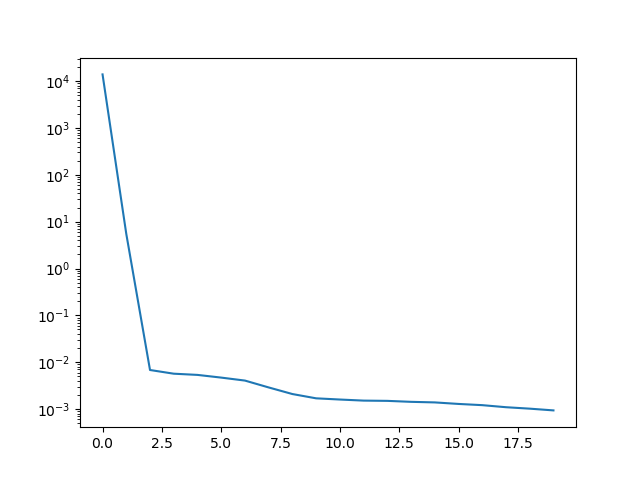

In [15]:
Conv = [0]*(len(InnerPts)-1)
for i in range(len(InnerPts)-1):
    Conv[i]=np.sum( np.abs((InnerPts[i+1]-InnerPts[i])/(InnerPts[i+1]+0.001)) )/n
fig3, ax4 = plt.subplots()
ax4.set_yscale('log')
ax4.plot(Conv)

In [16]:
MaskMat[1,0:5]/(MaskMat[160,55:60]+np.arange(5))


array([1.        , 0.99609375, 0.9922179 , 0.98837209, 0.98455598])

In [17]:
# [j,k]=[65, 187]
# Pts0[j-2:j+4,k-2:k+3]
# bc[j-2:j+4,k-2:k+3]
# Pts0[j,k]

# I[j-2:j+4,k-2:k+3]

In [18]:
# (bc[j-1,k] + Pts0[j,k-1] + Pts0[j,k+1] + Pts0[j+1,k])/4
# InnerPts[1,j,k]

This is for my git

In [19]:
# ! git remote add origin https://github.com/AndrissP/ImageRestore.git   
# ! git push --set-upstream origin master
# ! git add -u
#! git commit -m 'Jacoby_works'
# ! git push
# ! git status

In [20]:
### The link in the description does not work. It is scipy.fftpack that does not load
#from scipy.fftpack import fft

# import skimage.io
# import numpy as np
# import skimage.viewer
# from matplotlib import pyplot as plt
# import sys